
# MovieLens 100K
**dataset**: https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset/dataN.


In [1]:

# %%capture
!pip install -q numpy pandas scikit-learn tensorflow


In [ ]:
import kagglehub
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## 1) Carga de datos (MovieLens 100K)

In [3]:
!pip install kagglehub

In [4]:

#dataset
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")
print("Dataset descargado en:", path)

100%|██████████| 4.77M/4.77M [00:00<00:00, 48.5MB/s]

Extracting files...


Dataset descargado en: /root/.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1


In [6]:
src = os.path.join(path, "ml-100k")
dst = "/content/ml-100k"

shutil.copytree(src, dst, dirs_exist_ok=True)
!ls -lah /content/ml-100k

total 16M
drwxr-xr-x 2 root root 4.0K Sep  8 02:59 .
drwxr-xr-x 1 root root 4.0K Sep  8 02:59 ..
-rw-r--r-- 1 root root  716 Sep  8 02:59 allbut.pl
-rw-r--r-- 1 root root  643 Sep  8 02:59 mku.sh
-rw-r--r-- 1 root root 6.6K Sep  8 02:59 README
-rw-r--r-- 1 root root 1.6M Sep  8 02:59 u1.base
-rw-r--r-- 1 root root 384K Sep  8 02:59 u1.test
-rw-r--r-- 1 root root 1.6M Sep  8 02:59 u2.base
-rw-r--r-- 1 root root 386K Sep  8 02:59 u2.test
-rw-r--r-- 1 root root 1.6M Sep  8 02:59 u3.base
-rw-r--r-- 1 root root 388K Sep  8 02:59 u3.test
-rw-r--r-- 1 root root 1.6M Sep  8 02:59 u4.base
-rw-r--r-- 1 root root 388K Sep  8 02:59 u4.test
-rw-r--r-- 1 root root 1.6M Sep  8 02:59 u5.base
-rw-r--r-- 1 root root 389K Sep  8 02:59 u5.test
-rw-r--r-- 1 root root 1.8M Sep  8 02:59 ua.base
-rw-r--r-- 1 root root 183K Sep  8 02:59 ua.test
-rw-r--r-- 1 root root 1.8M Sep  8 02:59 ub.base
-rw-r--r-- 1 root root 183K Sep  8 02:59 ub.test
-rw-r--r-- 1 root root 1.9M Sep  8 02:59 u.data
-rw-r--r-- 1 root root

In [7]:
# Ajusta esta ruta si lo tienes en otra carpeta (Colab: /content/ml-100k/)
DATA_DIR = "/content/ml-100k"

# u.data
calificaciones = pd.read_csv(
    f"{DATA_DIR}/u.data",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"],
    engine="python"
)

# u.item
columnas_item = [
    "movie_id", "title", "release_date", "video_release_date", "imdb_url",
    "unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
catalogo = pd.read_csv(
    f"{DATA_DIR}/u.item",
    sep="|",
    names=columnas_item,
    encoding="latin-1"
)

# u.user
infouser = pd.read_csv(
    f"{DATA_DIR}/u.user",
    sep="|",
    names=["user_id", "age", "gender", "occupation", "zip"],
    engine="python"
)

print("Shapes -> calificaciones:", calificaciones.shape,
      "catalogo:", catalogo.shape, "infouser:", infouser.shape)
calificaciones.head()


Shapes -> calificaciones: (100000, 4) catalogo: (1682, 24) infouser: (943, 5)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 2) Subset de usuarios más activos y (opcional) filtro de ítems populares

In [8]:

# Parámetros del subset
TOP_U = 300   # usuarios más activos
MIN_ITM = 20  # mínimo de ratings por película

user_counts = calificaciones['user_id'].value_counts()
top_users = user_counts.head(TOP_U).index

subset = calificaciones[calificaciones['user_id'].isin(top_users)].copy()

if MIN_ITM is not None:
    item_counts = subset['item_id'].value_counts()
    popular_items = item_counts[item_counts >= MIN_ITM].index
    subset = subset[subset['item_id'].isin(popular_items)].copy()

# Reindexar a índices consecutivos
u_ids = subset['user_id'].unique()
i_ids = subset['item_id'].unique()
u2idx = {u:i for i,u in enumerate(u_ids)}
i2idx = {m:i for i,m in enumerate(i_ids)}
idx2u = {i:u for u,i in u2idx.items()}
idx2i = {i:m for m,i in i2idx.items()}

subset['u'] = subset['user_id'].map(u2idx)
subset['i'] = subset['item_id'].map(i2idx)
subset['rating'] = subset['rating'].astype(np.float32)

n_users = len(u_ids); n_items = len(i_ids)
print("Subset -> usuarios:", n_users, "| items:", n_items, "| filas:", len(subset))
subset.head()


Subset -> usuarios: 300 | items: 826 | filas: 61879


,user_id,item_id,rating,timestamp,u,i
3,244,51,2.0,880606923,0,0
5,298,474,4.0,884182806,1,1
8,305,451,3.0,886324817,2,2
9,6,86,3.0,883603013,3,3
10,62,257,2.0,879372434,4,4


## 3) Hold-out por usuario: train/val/test

In [9]:
def per_user_holdout(df, test_size=0.1, val_size=0.1, seed=42):
    rng = np.random.RandomState(seed)
    test_idx, val_idx = [], []

    for u, group in df.groupby('u'):
        idx = group.index.values
        if len(idx) < 5:
            continue
        test_n = max(1, int(len(idx) * test_size))
        val_n  = max(1, int(len(idx) * val_size))
        pick = rng.permutation(idx)
        test_idx.extend(pick[:test_n])
        val_idx.extend(pick[test_n:test_n+val_n])

    test_mask = df.index.isin(test_idx)
    val_mask  = df.index.isin(val_idx)
    train = df[~(test_mask | val_mask)].copy()
    val   = df[val_mask].copy()
    test  = df[test_mask].copy()
    return train, val, test

train, val, test = per_user_holdout(subset, test_size=0.1, val_size=0.1, seed=42)
len(train), len(val), len(test)


(49761, 6059, 6059)

## 4) Matrices densas y máscaras

In [10]:

def build_dense(df, n_users, n_items):
    M = np.zeros((n_users, n_items), dtype=np.float32)
    for _, row in df.iterrows():
        M[int(row['u']), int(row['i'])] = row['rating']
    return M

Y_train = build_dense(train, n_users, n_items)
Y_val   = build_dense(val,   n_users, n_items)
Y_test  = build_dense(test,  n_users, n_items)

W_train = (Y_train > 0).astype(np.float32)
W_val   = (Y_val   > 0).astype(np.float32)
W_test  = (Y_test  > 0).astype(np.float32)

Y_train.shape, Y_val.shape, Y_test.shape


((300, 826), (300, 826), (300, 826))

## 5) Autoencoder con pérdida enmascarada (Keras)

In [11]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    denom = tf.reduce_sum(mask) + 1e-8
    return tf.reduce_sum(tf.square((y_true - y_pred) * mask)) / denom

inp = keras.Input(shape=(n_items,), name="user_vector")
x = layers.Dense(512, activation="relu")(inp)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)  # bottleneck
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
out = layers.Dense(n_items, activation="linear")(x)

ae = keras.Model(inp, out)
ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss=masked_mse)

ae.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_vector (InputLayer)        │ (None, 826)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       423,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 826)            │       423,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,175,994 (4.49 MB)

 Trainable params: 1,175,994 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

## 6) Entrenamiento con early-stopping

In [12]:

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
history = ae.fit(
    Y_train, Y_train,
    validation_data=(Y_val, Y_val),
    epochs=30,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 12.5706 - val_loss: 8.8544
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.2627 - val_loss: 9.7491
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.5455 - val_loss: 7.8452
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.7465 - val_loss: 7.1504
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3430 - val_loss: 7.0489
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1809 - val_loss: 5.6771
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0938 - val_loss: 5.9928
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9922 - val_loss: 6.0707
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.9799 - val_loss: 5.4793
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.9655 - val_loss: 6.0056
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.8765 - val_loss: 5.6218
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8679 - val_loss: 5.7517


## 7) Curva de entrenamiento

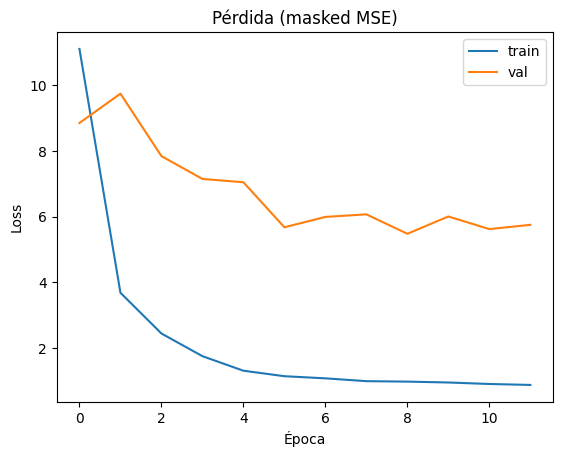

In [13]:


plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Pérdida (masked MSE)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 8) Evaluación RMSE en test (solo ratings observados)

In [14]:

pred_test = ae.predict(Y_test, verbose=0).astype(np.float32)
pred_test = np.clip(pred_test, 1.0, 5.0)  # escala de MovieLens

mask = W_test.astype(bool)
se = (Y_test[mask] - pred_test[mask])**2
rmse = np.sqrt(se.mean())
print("RMSE (Test):", round(float(rmse), 4))


RMSE (Test): 2.3427


## 9) Recomendación Top-N para un usuario del subset

In [15]:

def recomendar_autoencoder(u_id_real, top_n=10):
    if u_id_real not in u2idx:
        return pd.DataFrame({"info":[
            "Usuario fuera del subset del autoencoder (elige uno de u_ids)"
        ]})
    u = u2idx[u_id_real]
    scores = ae.predict(Y_train[[u]], verbose=0)[0]
    scores = np.clip(scores, 1.0, 5.0)

    # Excluir ítems ya vistos por el usuario en TRAIN
    vistos = set(train[train['u'] == u]['i'].tolist())
    cand_idx = [i for i in range(n_items) if i not in vistos]

    top_idx = np.argsort(-scores[cand_idx])[:top_n]
    rec_i = [cand_idx[i] for i in top_idx]
    rec_movie_ids = [idx2i[i] for i in rec_i]

    rec = catalogo[catalogo['movie_id'].isin(rec_movie_ids)][['movie_id','title']].copy()
    order_map = {mid: rank for rank, mid in enumerate(rec_movie_ids)}
    rec['rank'] = rec['movie_id'].map(order_map)
    rec = rec.sort_values('rank').drop(columns='rank').reset_index(drop=True)
    return rec

# Ejemplo: primer usuario del subset
ejemplo_user = int(u_ids[0])
recomendar_autoencoder(ejemplo_user, top_n=10)


,movie_id,title
0,488,Sunset Blvd. (1950)
1,316,As Good As It Gets (1997)
2,1194,Once Were Warriors (1994)
3,511,Lawrence of Arabia (1962)
4,98,"Silence of the Lambs, The (1991)"
5,525,"Big Sleep, The (1946)"
6,136,Mr. Smith Goes to Washington (1939)
7,134,Citizen Kane (1941)
8,603,Rear Window (1954)
9,483,Casablanca (1942)


## 10) Visualizacion


In [16]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# extraer año desde el título (e.g., "Toy Story (1995)")
def year_from_title(t):
    m = re.search(r'\((\d{4})\)', str(t))
    return int(m.group(1)) if m else np.nan

catalogo['year'] = catalogo['title'].apply(year_from_title)

# columnas de géneros
genre_cols = ["unknown","Action","Adventure","Animation","Children","Comedy",
              "Crime","Documentary","Drama","Fantasy","Film-Noir","Horror",
              "Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

# join para tener títulos en calificaciones
ratings_movies = calificaciones.merge(catalogo[['movie_id','title','year']],
                                      left_on='item_id', right_on='movie_id', how='left')

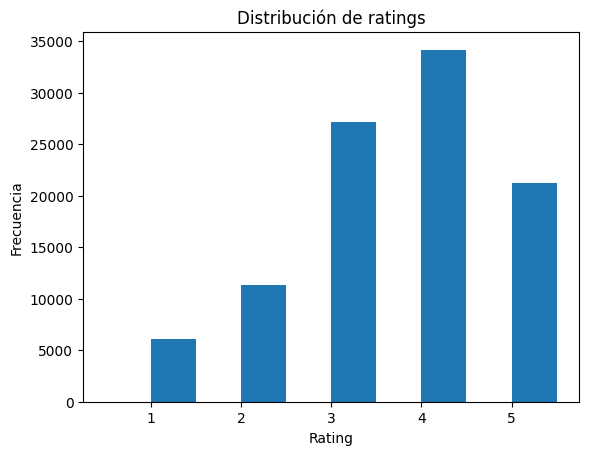

In [17]:
plt.figure()
plt.hist(calificaciones['rating'], bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])
plt.title("Distribución de ratings")
plt.xlabel("Rating"); plt.ylabel("Frecuencia")
plt.show()

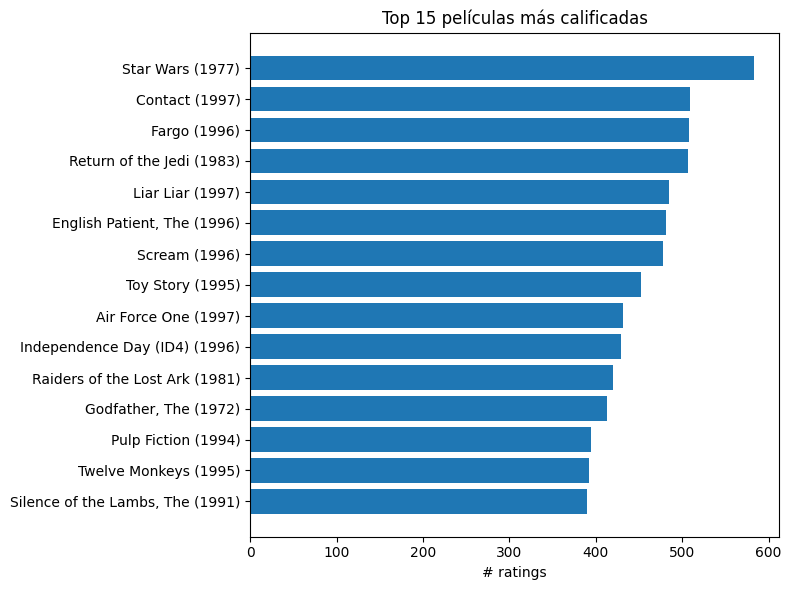

In [20]:
top_movies = (calificaciones.groupby('item_id')['rating'].count()
              .sort_values(ascending=False).head(15)).reset_index()
top_movies = top_movies.merge(catalogo[['movie_id','title']], left_on='item_id', right_on='movie_id')

plt.figure(figsize=(8,6))
plt.barh(top_movies['title'][::-1], top_movies['rating'][::-1])
plt.title("Top 15 películas más calificadas")
plt.xlabel("# ratings"); plt.tight_layout(); plt.show()

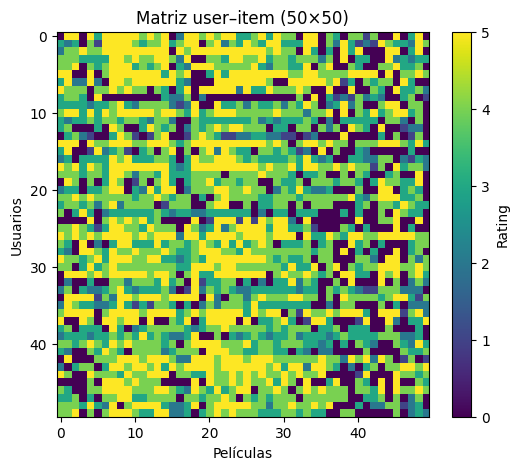

In [22]:
# usuarios y películas más activos para una ventanita visible
top_u = cnt_u.sort_values(ascending=False).head(50).index
top_i = cnt_m.sort_values(ascending=False).head(50).index
pivot = (calificaciones[calificaciones['user_id'].isin(top_u) &
                        calificaciones['item_id'].isin(top_i)]
         .pivot_table(index='user_id', columns='item_id', values='rating'))

plt.figure(figsize=(6,5))
plt.imshow(pivot.fillna(0).values, aspect='auto')
plt.colorbar(label='Rating')
plt.title("Matriz user–item (50×50)")
plt.xlabel("Películas"); plt.ylabel("Usuarios")
plt.show()

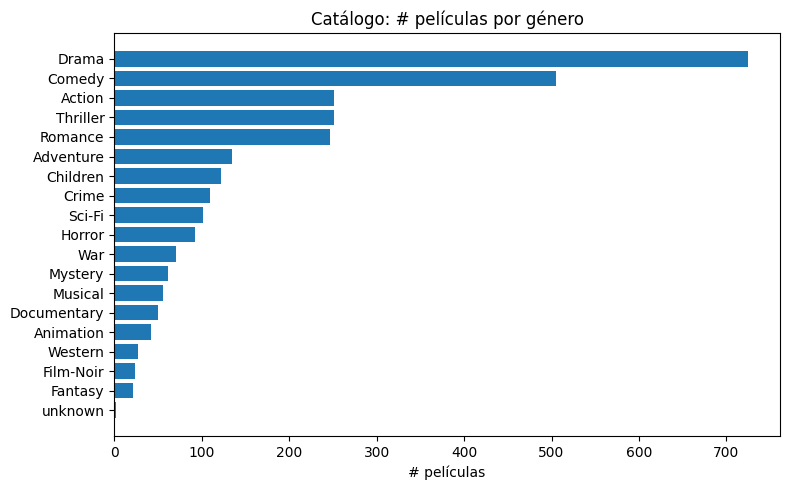

In [23]:
genre_counts = catalogo[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.barh(genre_counts.index[::-1], genre_counts.values[::-1])
plt.title("Catálogo: # películas por género")
plt.xlabel("# películas"); plt.tight_layout(); plt.show()

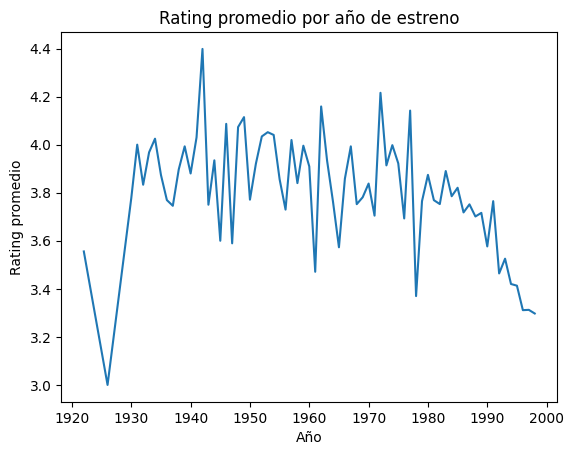

In [25]:
year_mean = ratings_movies.dropna(subset=['year']).groupby('year')['rating'].mean()
plt.figure()
plt.plot(year_mean.index, year_mean.values)
plt.title("Rating promedio por año de estreno")
plt.xlabel("Año"); plt.ylabel("Rating promedio")
plt.show()


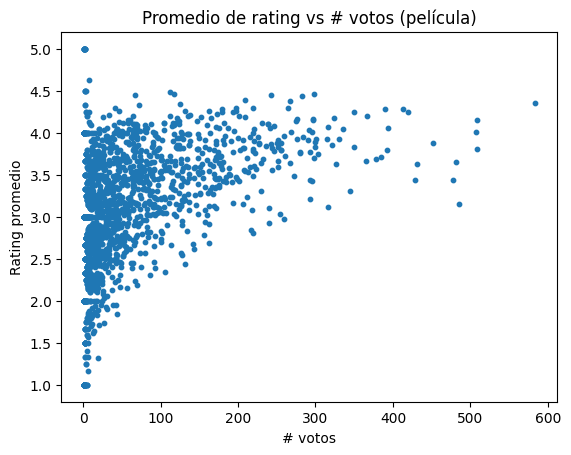

In [28]:
movie_stats = calificaciones.groupby('item_id')['rating'].agg(['mean','count']).reset_index()
plt.figure()
plt.scatter(movie_stats['count'], movie_stats['mean'], s=10)
plt.title("Promedio de rating vs # votos (película)")
plt.xlabel("# votos"); plt.ylabel("Rating promedio")
plt.show()

## 11) Sistema de embeddings

In [32]:
# --- MAPEOS A ÍNDICES ---
user2idx = {u:i for i,u in enumerate(calificaciones['user_id'].unique())}
item2idx = {m:i for i,m in enumerate(calificaciones['item_id'].unique())}

df = calificaciones.copy()
df['user_idx'] = df['user_id'].map(user2idx)
df['item_idx'] = df['item_id'].map(item2idx)
df['rating']   = df['rating'].astype('float32')

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val  = train_test_split(train, test_size=0.1, random_state=42)

X_train = [train['user_idx'].values, train['item_idx'].values]
y_train = train['rating'].values
X_val   = [val['user_idx'].values,   val['item_idx'].values]
y_val   = val['rating'].values
X_test  = [test['user_idx'].values,  test['item_idx'].values]
y_test  = test['rating'].values

n_users = len(user2idx); n_items = len(item2idx); k = 64  # dim embedding


In [33]:
# --- MODELO EMBEDDINGS ---
user_in = keras.Input(shape=(1,), name='user')
item_in = keras.Input(shape=(1,), name='item')

user_emb = layers.Embedding(n_users, k, name='user_emb')(user_in)
item_emb = layers.Embedding(n_items, k, name='item_emb')(item_in)

u = layers.Flatten()(user_emb)
i = layers.Flatten()(item_emb)

x = layers.Concatenate()([u, i])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
pred = layers.Dense(1, activation='linear')(x)   # rating 1..5

emb_model = keras.Model([user_in, item_in], pred)
emb_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
hist_emb = emb_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=10, batch_size=1024, verbose=1)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.0999 - mae: 2.4378 - val_loss: 0.9602 - val_mae: 0.7807
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8868 - mae: 0.7460 - val_loss: 0.9215 - val_mae: 0.7555
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8608 - mae: 0.7329 - val_loss: 0.9188 - val_mae: 0.7602
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8517 - mae: 0.7280 - val_loss: 0.9171 - val_mae: 0.7592
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8546 - mae: 0.7304 - val_loss: 0.9086 - val_mae: 0.7503
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8417 - mae: 0.7250 - val_loss: 0.9051 - val_mae: 0.7515
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8356 - mae: 0.7223 - val_loss: 0.9019 - val_mae: 0.7489
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8317 - mae: 0.7193 - val_loss: 0.8958 - val_mae: 0.7475
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.819

In [34]:
# --- EVALUACIÓN (RMSE / MAE) ---
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred = emb_model.predict(X_test, verbose=0).ravel()
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
print(f"[Embeddings] RMSE={rmse:.4f} | MAE={mae:.4f}")

[Embeddings] RMSE=0.9348 | MAE=0.7344


## 12) Sistema Hibrodo

In [38]:
# --- MATRIZ DE GÉNEROS (19 columnas) ALINEADA A item_idx ---
genre_cols = ["unknown","Action","Adventure","Animation","Children","Comedy",
              "Crime","Documentary","Drama","Fantasy","Film-Noir","Horror",
              "Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

# ordena catálogo según item2idx
cat = catalogo.set_index('movie_id').reindex([k for k,_ in sorted(item2idx.items(), key=lambda x:x[1])])
content = cat[genre_cols].fillna(0).to_numpy(dtype='float32')   # shape: (n_items, 19)

content_tf = tf.constant(content)

class ItemContent(layers.Layer):
    def __init__(self, content_tensor):
        super().__init__()
        self.content = content_tensor  # (n_items, 19)
    def call(self, item_idx):
        item_idx = tf.cast(tf.squeeze(item_idx, axis=1), tf.int32)
        return tf.gather(self.content, item_idx) # (batch, 19)


In [39]:
# --- MODELO HÍBRIDO ---
user_in = keras.Input(shape=(1,), dtype='int32', name='user')
item_in = keras.Input(shape=(1,), dtype='int32', name='item')

user_emb = layers.Embedding(n_users, k, name='user_emb')(user_in)
item_emb = layers.Embedding(n_items, k, name='item_emb')(item_in)
u = layers.Flatten()(user_emb)
i = layers.Flatten()(item_emb)

i_content = ItemContent(content_tf)(item_in)  # (batch, 19)

h = layers.Concatenate()([u, i, i_content])
h = layers.Dense(128, activation='relu')(h)
h = layers.Dense(64, activation='relu')(h)
out = layers.Dense(1, activation='linear')(h)

hybrid = keras.Model([user_in, item_in], out)
hybrid.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
hist_h = hybrid.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=10, batch_size=1024, verbose=1)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.5901 - mae: 2.3402 - val_loss: 0.9536 - val_mae: 0.7787
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8890 - mae: 0.7468 - val_loss: 0.9140 - val_mae: 0.7547
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8613 - mae: 0.7336 - val_loss: 0.9053 - val_mae: 0.7482
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8456 - mae: 0.7255 - val_loss: 0.9001 - val_mae: 0.7484
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8351 - mae: 0.7216 - val_loss: 0.8942 - val_mae: 0.7497
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8158 - mae: 0.7127 - val_loss: 0.8845 - val_mae: 0.7401
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8009 - mae: 0.7064 - val_loss: 0.8821 - val_mae: 0.7413
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7819 - mae: 0.6957 - val_loss: 0.8762 - val_mae: 0.7361
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7627

In [40]:
# --- EVALUACIÓN HÍBRIDO ---
pred_h = hybrid.predict(X_test, verbose=0).ravel()
rmse_h = np.sqrt(mean_squared_error(y_test, pred_h))
mae_h  = mean_absolute_error(y_test, pred_h)
print(f"[Híbrido] RMSE={rmse_h:.4f} | MAE={mae_h:.4f}")
print(f"Mejora RMSE vs Embeddings: {rmse - rmse_h:.4f}")


[Híbrido] RMSE=0.9221 | MAE=0.7237
Mejora RMSE vs Embeddings: 0.0127


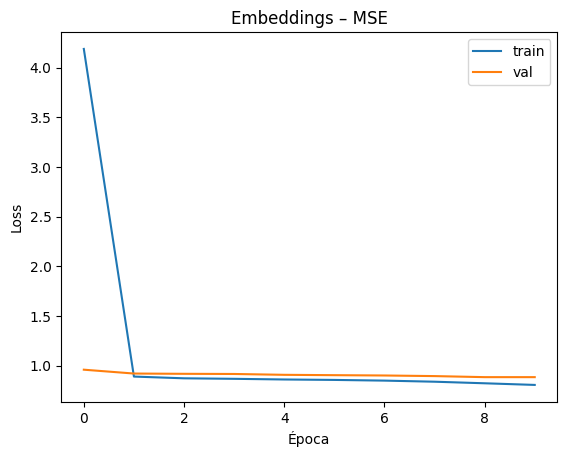

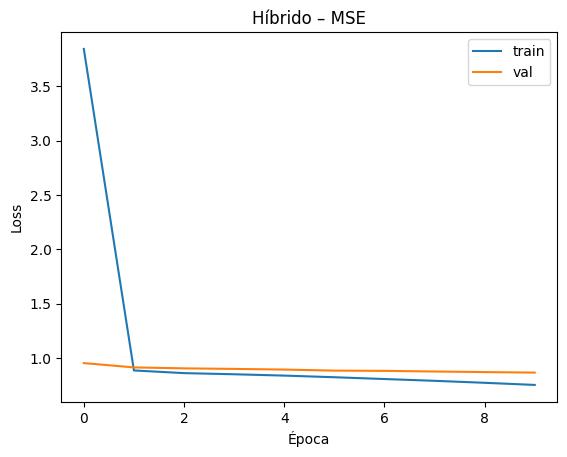

In [41]:
import matplotlib.pyplot as plt

def plot_history(h, title):
    plt.figure()
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title(title); plt.xlabel('Época'); plt.ylabel('Loss'); plt.legend(); plt.show()

plot_history(hist_emb, "Embeddings – MSE")
plot_history(hist_h,   "Híbrido – MSE")

## 12) Top-N pelis que aún no vio un usuario

In [54]:
# idx inverso para volver de índice interno -> movie_id
idx2item = {v: k for k, v in item2idx.items()}

def recomendar_topn_usuario(model, user_id, n=10, clip=True):
    """
    Devuelve Top-N recomendaciones para un usuario EXISTENTE,
    excluyendo ítems que ya calificó.
    """
    if user_id not in user2idx:
        raise ValueError(f"user_id {user_id} no existe en user2idx")

    uidx = np.int32(user2idx[user_id])

    # universo de items (idx internos)
    items = np.arange(len(item2idx), dtype=np.int32)
    users = np.full_like(items, uidx)  # vector con el mismo user para todos los items

    # excluir ya vistos por ese usuario (según df con user_idx/item_idx)
    vistos_idx = df.loc[df["user_idx"] == uidx, "item_idx"].unique()
    mask = np.ones(items.shape[0], dtype=bool)
    mask[vistos_idx] = False

    items_infer = items[mask]
    users_infer = users[mask]

    # predicción en batch (rápido)
    scores = model.predict([users_infer, items_infer], batch_size=4096, verbose=0).ravel()
    if clip:
        scores = np.clip(scores, 1.0, 5.0)  # escala MovieLens (opcional)

    # top-N
    top_pos = np.argsort(-scores)[:n]
    top_item_idx = items_infer[top_pos]
    top_scores = scores[top_pos]

    # mapear a movie_id y traer títulos
    mids = [idx2item[i] for i in top_item_idx]
    out = catalogo.loc[catalogo["movie_id"].isin(mids), ["movie_id", "title"]].copy()

    # mantener el orden de los scores
    orden = {mid: i for i, mid in enumerate(mids)}
    out["rank"] = out["movie_id"].map(orden)
    out["pred_rating"] = out["movie_id"].map({m:s for m,s in zip(mids, top_scores)})
    out = out.sort_values("rank").drop(columns="rank").reset_index(drop=True)
    return out


In [58]:
#Agregar ID

recs_h = recomendar_topn_usuario(hybrid, user_id=115, n=5)
display(recs_h)

recs_e = recomendar_topn_usuario(emb_model, user_id=115, n=5)
display(recs_e)

,movie_id,title,pred_rating
0,320,Paradise Lost: The Child Murders at Robin Hood...,5.0
1,1536,Aiqing wansui (1994),5.0
2,1189,Prefontaine (1997),5.0
3,1631,"Slingshot, The (1993)",5.0
4,1398,Anna (1996),5.0


,movie_id,title,pred_rating
0,1449,Pather Panchali (1955),5.000000
1,1536,Aiqing wansui (1994),4.846767
2,1398,Anna (1996),4.769216
3,320,Paradise Lost: The Child Murders at Robin Hood...,4.768352
4,1306,Delta of Venus (1994),4.742272


## 13)Evaluación y análisis de resultados
##  Embeddings vs Híbrido

In [59]:
def eval_rmse_mae(model, X_test, y_test):
    pred = model.predict(X_test, verbose=0).ravel()
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)
    return rmse, mae

rmse_e, mae_e = eval_rmse_mae(emb_model, X_test[:2], y_test)
rmse_h, mae_h = eval_rmse_mae(hybrid,    X_test[:2], y_test)
res_err = pd.DataFrame([
    ["Embeddings", rmse_e, mae_e],
    ["Híbrido",    rmse_h, mae_h],
], columns=["Modelo","RMSE","MAE"])
res_err

,Modelo,RMSE,MAE
0,Embeddings,0.934750,0.734421
1,Híbrido,0.922052,0.723726


## Ranking

In [60]:
# ── utilidades ─────────────────────────────────────────────────────────────
from collections import defaultdict

# mapas rápidos
idx2item = {v:k for k,v in item2idx.items()}
items_all = np.arange(len(item2idx), dtype=np.int32)

# conjuntos de “relevantes” en test por usuario (en índices internos)
test_rel = defaultdict(set)
for u,i in zip(test['user_idx'].values, test['item_idx'].values):
    test_rel[int(u)].add(int(i))

# vistos (train+val) por usuario para excluir al rankear
seen = defaultdict(set)
for df_split in [train, val]:
    for u,i in zip(df_split['user_idx'].values, df_split['item_idx'].values):
        seen[int(u)].add(int(i))

def precision_recall_ndcg_at_k(model, K=10, users_sample=None, batch=4096, clip=True):
    if users_sample is None:
        users_sample = sorted(test['user_idx'].unique())
    P, R, DCG, IDCG = [], [], [], []
    for u in users_sample:
        rel_set = test_rel.get(int(u), set())
        if not rel_set:
            continue  # sin test para ese user

        mask = np.ones_like(items_all, dtype=bool)
        if seen.get(int(u)):
            mask[list(seen[int(u)])] = False

        cand = items_all[mask]
        users = np.full_like(cand, u, dtype=np.int32)

        scores = model.predict([users, cand], batch_size=batch, verbose=0).ravel()
        if clip: scores = np.clip(scores, 1.0, 5.0)

        top_idx = np.argsort(-scores)[:K]
        top_items = cand[top_idx]

        hits = sum(1 for itm in top_items if int(itm) in rel_set)
        P.append(hits / K)
        R.append(hits / len(rel_set))

        # NDCG
        gains = [1 if int(itm) in rel_set else 0 for itm in top_items]
        dcg = sum(g/np.log2(r+2) for r,g in enumerate(gains))
        idcg = sum(1/np.log2(r+2) for r in range(min(len(rel_set), K)))
        DCG.append(dcg)
        IDCG.append(idcg if idcg>0 else 1.0)

    prec = float(np.mean(P)) if P else 0.0
    rec  = float(np.mean(R)) if R else 0.0
    ndcg = float(np.mean([d/i for d,i in zip(DCG,IDCG)])) if DCG else 0.0
    return prec, rec, ndcg

# ── evalúa en K=5 y K=10 ───────────────────────────────────────────────────
metrics = []
for K in (5,10):
    p,r,n = precision_recall_ndcg_at_k(emb_model, K=K)
    metrics.append(["Embeddings", K, p, r, n])
    p,r,n = precision_recall_ndcg_at_k(hybrid, K=K)
    metrics.append(["Híbrido", K, p, r, n])

res_rank = pd.DataFrame(metrics, columns=["Modelo","K","Precision","Recall","NDCG"])
res_rank


,Modelo,K,Precision,Recall,NDCG
0,Embeddings,5,0.007514,0.001817,0.006442
1,Híbrido,5,0.027845,0.012106,0.033380
2,Embeddings,10,0.008508,0.006278,0.008002
3,Híbrido,10,0.022431,0.021114,0.030925
